In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./libs')

import matplotlib.pyplot as plt
import colorcet as cc
import numpy as np
import pandas as pd
import h5py
from ipywidgets import interact, widgets
import vismesh_funcs as atsvis
import ats_xdmf as ats_xdmf
import pyvista as pv
# pv.set_plot_theme('dark')
# pv.global_theme.axes.show = False
pv.global_theme.smooth_shading = True

### Visualize exodus2 mesh

In [ ]:
domain_mesh = atsvis.load_mesh_exodus('../data/toy_catchment.exo', z_scale=20)
atsvis.plot_mesh(domain_mesh, show_scalar_bar=True, set_background=False, cmap='jet', 
                 opacity=1, show_toplayer=True, window_size=[1200, 600])

### Plot surface and subsurface data

In [3]:
data_directory = '../1.Hydrology/results/'
domain = h5py.File(f'{data_directory}/ats_vis_data.h5', 'r')
domain_polygons = atsvis.GetMeshPolygons(f'{data_directory}/ats_vis_mesh.h5')
surface = h5py.File(f'{data_directory}/ats_vis_surface_data.h5', 'r')
surface_polygons = atsvis.GetMeshPolygons(f'{data_directory}/ats_vis_surface_mesh.h5')

In [4]:
# loading domain mesh file
vis_domain = ats_xdmf.VisFile(data_directory, time_unit='hr')
vis_domain.loadMesh()

# loading surface mesh file
vis_surface = ats_xdmf.VisFile(data_directory, domain='surface', time_unit='hr')
vis_surface.loadMesh()

# getting time and number of steps
time = vis_domain.times
num_steps = len(vis_domain.cycles)
num_surface_elements = np.shape(vis_surface.centroids)[0]
num_layers = int(np.shape(vis_domain.centroids)[0] / num_surface_elements)
print(f'Number of times: {num_steps}')
print(f'Number of surface elements: {num_surface_elements}')
print(f'Number of layers: {num_layers}')

Number of times: 49
Number of surface elements: 1659
Number of layers: 7


In [17]:
vis_domain.cycles

['0',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '18',
 '20',
 '22',
 '24',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '42',
 '44',
 '46',
 '48',
 '49',
 '50',
 '52',
 '54',
 '56',
 '58',
 '60',
 '62',
 '64',
 '66',
 '68',
 '71',
 '72',
 '74',
 '77',
 '80',
 '83',
 '86',
 '89']

In [5]:
vars_surface = ['pres_elev', 'ponded_depth', 'overland_conductivity']
interact(
    lambda step: atsvis.plot_surface(
        vars_surface,
        surface_polygons,
        vis_surface,
        step,
        time,
        vmin=[None, 0, None],
        vmax=[None, 1, None],
        cmap=[None, cc.cm.CET_L17, None]
    ),
    step=widgets.IntSlider(min=0, max=num_steps-1, step=1)
)

interactive(children=(IntSlider(value=0, description='step', max=48), Output()), _dom_classes=('widget-interac…

<function __main__.<lambda>(step)>

In [6]:
vars_subsurface = ['pressure', 'saturation_liquid']
interact(
    lambda step, layer: atsvis.plot_domain(
        vars_subsurface,
        surface_polygons,
        vis_domain,
        num_surface_elements,
        step,
        time,
        layer,
        vmin=[None, 0.8],
        vmax=[None, 1],
        cmap = [cc.cm.CET_R4, cc.cm.CET_R4]
    ),
    step=widgets.IntSlider(min=0, max=num_steps-1, step=1),
    layer=widgets.IntSlider(min=0, max=num_layers-1, step=1)
)

interactive(children=(IntSlider(value=0, description='step', max=48), IntSlider(value=0, description='layer', …

<function __main__.<lambda>(step, layer)>

In [7]:
fname = f'{data_directory}/observations.csv'
num_lines = atsvis.get_skip_number(fname)
ts_all = pd.read_csv(fname,skiprows=num_lines,sep=",")  

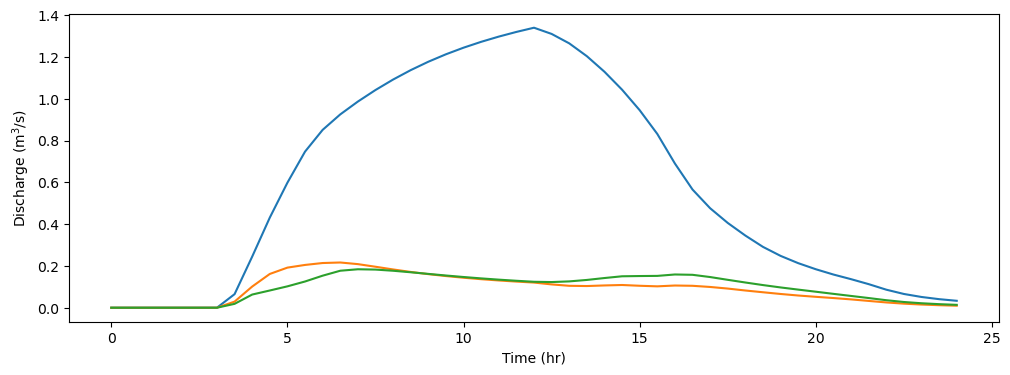

In [8]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(ts_all['time [h]'], ts_all['surface-flux-outlet']/55500)
ax.plot(ts_all['time [h]'], -ts_all['surface-flux-left-branch']/55500)
ax.plot(ts_all['time [h]'], -ts_all['surface-flux-right-branch']/55500)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Discharge (m$^3$/s)')
plt.show()


In [9]:
domain['saturation_liquid']
cycles = list(sorted(domain['saturation_liquid'].keys(), key=int))
times = np.array([domain['saturation_liquid'][cycle].attrs['Time'] for cycle in cycles])

In [10]:
print(cycles[10])
print(times[10])

24
5.0


In [13]:
p = pv.Plotter()
p.enable_anti_aliasing()  # Sharper quality in local rendering
def create_mesh(value) -> None:
    steps = int(value)
    domain_mesh["saturation_liquid"] = domain['saturation_liquid'][str(steps)]
    p.add_mesh(
        domain_mesh,
        scalars="saturation_liquid",
        show_scalar_bar=True,
        lighting=False,
        cmap='jet',
        show_edges=True
    )    
p.add_slider_widget(create_mesh, [int(cycles[0]), int(cycles[-1])], title="Step")
p.show(interactive_update=True)

Widget(value='<iframe src="http://localhost:55425/index.html?ui=P_0x12de6e0d0_3&reconnect=auto" class="pyvista…